In [ ]:
import diffusers, torch
from torch.utils.data import DataLoader
import os
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.utils import save_image, make_grid
import torchvision

c:\Users\DHRUV\anaconda3\envs\image\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32,32)),
    transforms.Normalize(mean = (0.5,), std = (0.5,))
])

In [3]:
data = torchvision.datasets.FashionMNIST(
    "fashion_mnist",
    train = True,
    download=False,
    transform=transform
)

In [4]:
dataset = DataLoader(data,batch_size=32,shuffle=True)

In [5]:
for i in dataset:
    print(i[0].shape)
    break

torch.Size([32, 1, 32, 32])


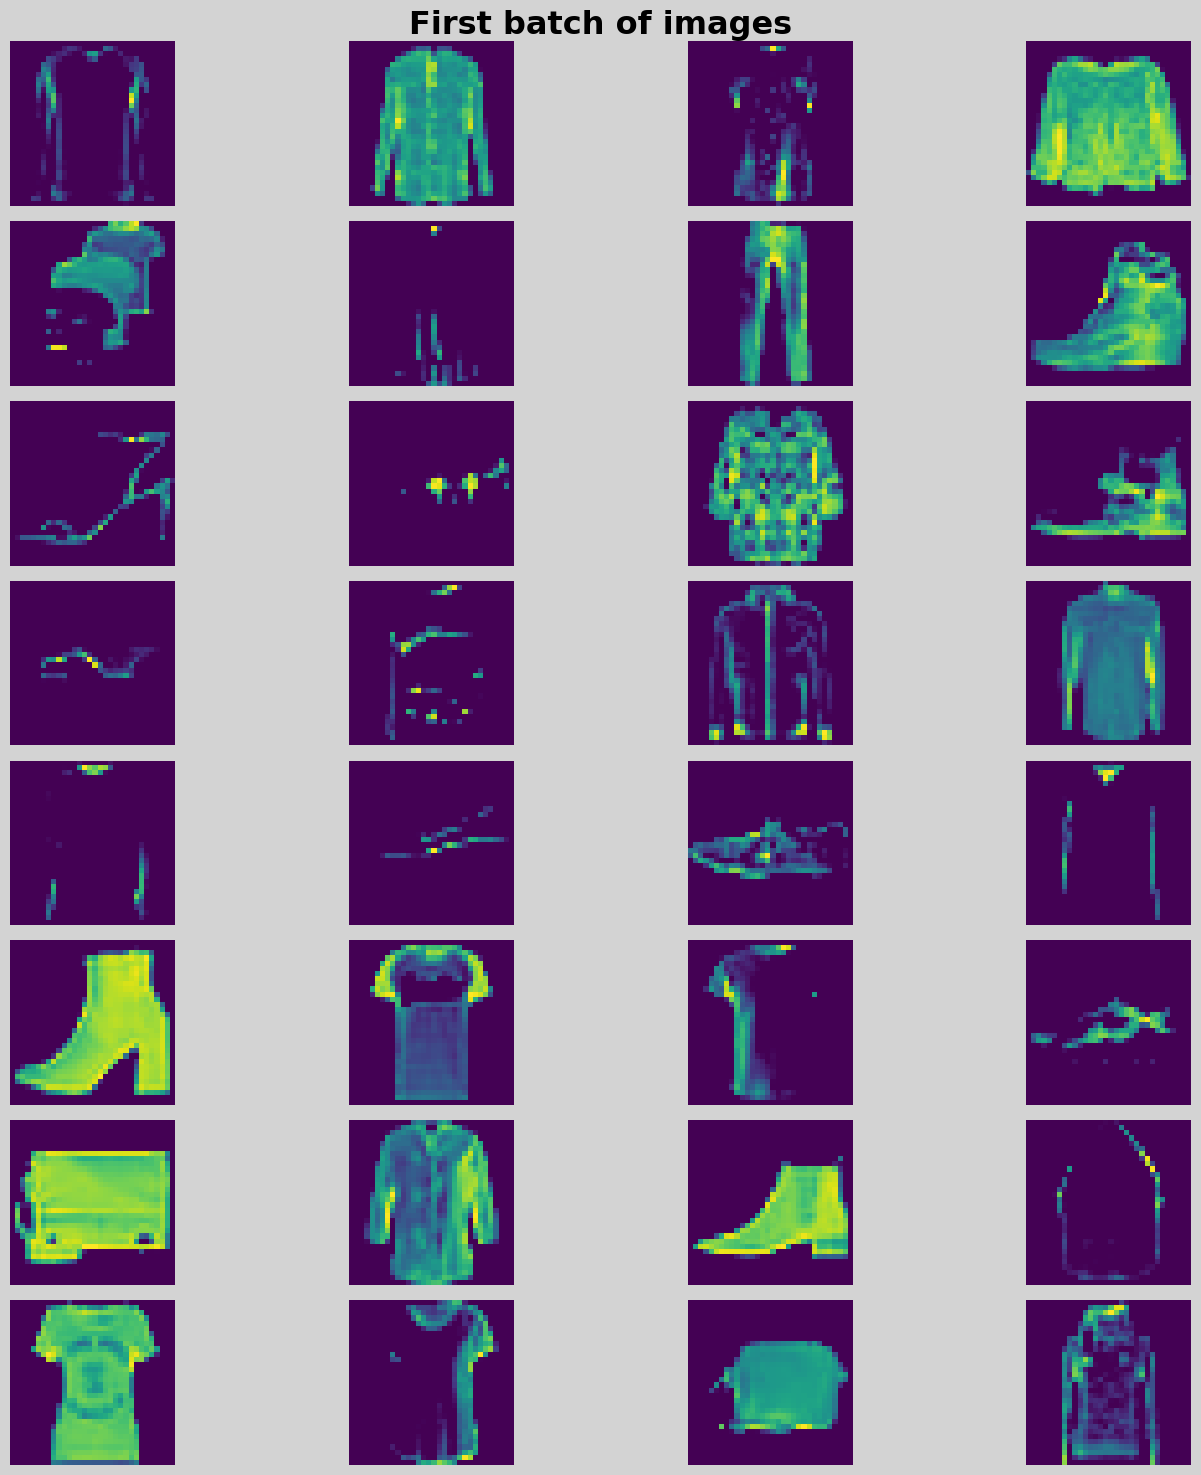

In [6]:
fig,axes = plt.subplots(8,4,figsize = (15,15))
fig.suptitle("First batch of images", fontsize = 23, fontweight = "bold")
axes = axes.flatten()

fig.patch.set_facecolor("lightgrey")

img,label = next(iter(dataset))

for ind in range(32):
    ax = axes[ind]
    image = img[ind]
    
    image = image.detach().cpu().numpy().transpose(1,2,0)
    image = np.clip(image,0,255)
    ax.imshow(image)
    ax.axis(False)

plt.tight_layout()
plt.show()

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = diffusers.UNet2DModel(sample_size=(32,32),in_channels=1,out_channels=1,layers_per_block=2,block_out_channels=(128,128,256,512),down_block_types=("DownBlock2D","DownBlock2D",
 "AttnDownBlock2D","DownBlock2D",),up_block_types=("UpBlock2D","AttnUpBlock2D",  #D
 "UpBlock2D","UpBlock2D",),).to(device)

In [8]:
noise_scheduler = diffusers.DDPMScheduler(num_train_timesteps=1000,beta_schedule="squaredcos_cap_v2")

In [16]:
@torch.no_grad()
def sample(n_sample, model, noise_scheduler, seed = None):
    if seed is not None:
        torch.manual_seed(seed)
    
    image = torch.randn(size = (n_sample,1,32,32)).to(device)
    noise_scheduler.set_timesteps(1000)

    for t in noise_scheduler.timesteps:
        model_output = model(image,t)["sample"]
        image = noise_scheduler.step(model_output,int(t),image,generator=None)["prev_sample"]

    return image

In [9]:
optim = torch.optim.AdamW(model.parameters(),lr = 2e-4)

In [ ]:
num_epochs = 10
scaler = torch.cuda.amp.GradScaler() # type: ignore
device = "cuda" if torch.cuda.is_available() else "cpu"

for epoch in range(num_epochs):
    loss_check = None
    loss_ema = None
    p_bar = tqdm(dataset)

    for x,y in p_bar:
        x = x.to(device)
        with torch.cuda.amp.autocast(): # type: ignore
            noise = torch.randn_like(x, device=device)
            timesteps = torch.randint(0,noise_scheduler.config.num_train_timesteps,(x.shape[0],),device=device) # type: ignore

            noisy = noise_scheduler.add_noise(x,noise,timesteps) # type: ignore
            noise_pred = model(noisy,timesteps)["sample"]

            loss = torch.nn.functional.l1_loss(noisy,noise_pred)

        optim.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()

        if loss_ema is None:
            loss_ema = loss.item()
        else:
            loss_ema = 0.9 * loss_ema + 0.1 * loss.item()

        p_bar.set_description(f"loss : {loss_ema}")
        os.makedirs("model")
        xh = sample(32,model,noise_scheduler)
        grid = make_grid(0.5-xh/2,nrow=8)
        save_image(grid,f"model/diffusion_image{epoch}.png")

        if loss_check is None or loss_check > loss_ema:
            loss_check = loss_ema
            torch.save(model.state_dict(),"model/model_weights.pth")
        
        elif loss_check < loss_ema:
            torch.save(model.state_dict(),"model/model_weights.pth")

    torch.save(model.state_dict(),"model/model_weights.pth")

In [ ]:
state_dict = torch.load(r"model/model_weights.pth")

In [14]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [17]:
images = sample(32,model,noise_scheduler)

In [19]:
grid = make_grid(0.5 - images/2,nrow=8)
save_image(grid,"diffusion_fashion.png")

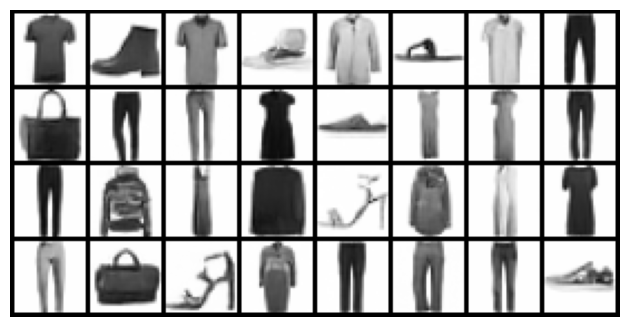

In [22]:
plt.imshow(grid.cpu().permute(1,2,0).numpy())
plt.axis(False)
plt.tight_layout()
plt.show()